# Predictive Maintenance of Industrial Equipment using Multimodal Data

## Project Phases
1) Data Collection and Preparation

2) Exploratory Data Analysis (EDA)

3) Feature Engineering

4) Model Building

5) Model Evaluation

6) Optimization & Deployment


###1.1 Data Sources:

Sensor data from equipment (temperature, vibration, pressure, etc.)

Maintenance logs

Operational parameters (load, speed, etc.)

External data (weather conditions, shift information)

###1.2 Data Cleaning:

Handle missing values through imputation or removal.
Normalize sensor data to handle different scales.
Merge datasets based on timestamps.

###1.3 Data Transformation:

Convert timestamps to datetime format.
Resample data to a common frequency (e.g., hourly).
Create labels indicating failure events.

###1.4 Train-Test Split:

Split the data into training and testing sets, ensuring failure events are appropriately represented in both.

In [ ]:
import pandas as pd
import numpy as np

# Generate timestamps
timestamps = pd.date_range(start='2023-01-01', periods=10000, freq='H')

# Generate sensor readings
np.random.seed(42)
sensor_data = pd.DataFrame({
    'timestamp': timestamps,
    'sensor_1': np.random.normal(loc=0.0, scale=1.0, size=len(timestamps)),
    'sensor_2': np.random.normal(loc=1.0, scale=1.5, size=len(timestamps)),
    'sensor_3': np.random.normal(loc=2.0, scale=2.0, size=len(timestamps)),
    'sensor_4': np.random.normal(loc=3.0, scale=2.5, size=len(timestamps)),
})

# Save to CSV
sensor_data.to_csv('sensor_data.csv', index=False)


In [ ]:
# Generate maintenance logs
maintenance_timestamps = timestamps[np.random.choice(len(timestamps), size=50, replace=False)]
maintenance_logs = pd.DataFrame({
    'timestamp': maintenance_timestamps,
    'failure': np.random.choice([0, 1], size=50, p=[0.7, 0.3])
})

# Save to CSV
maintenance_logs.to_csv('maintenance_logs.csv', index=False)


In [ ]:
# Generate operational parameters
operational_params = pd.DataFrame({
    'timestamp': timestamps,
    'load': np.random.uniform(low=50, high=100, size=len(timestamps)),
    'speed': np.random.uniform(low=1000, high=5000, size=len(timestamps))
})

# Save to CSV
operational_params.to_csv('operational_params.csv', index=False)


In [ ]:
# Generate weather data
weather_data = pd.DataFrame({
    'timestamp': timestamps,
    'temperature': np.random.uniform(low=-10, high=35, size=len(timestamps)),
    'humidity': np.random.uniform(low=20, high=80, size=len(timestamps))
})

# Save to CSV
weather_data.to_csv('weather_data.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.ensemble import IsolationForest
import joblib


In [ ]:
# Load the datasets
sensor_data = pd.read_csv('sensor_data.csv', parse_dates=['timestamp'], index_col='timestamp')
maintenance_logs = pd.read_csv('maintenance_logs.csv', parse_dates=['timestamp'], index_col='timestamp')
operational_params = pd.read_csv('operational_params.csv', parse_dates=['timestamp'], index_col='timestamp')
weather_data = pd.read_csv('weather_data.csv', parse_dates=['timestamp'], index_col='timestamp')


In [ ]:
# Merge datasets based on timestamp
data = sensor_data.join([maintenance_logs, operational_params, weather_data], how='outer').fillna(0)


In [ ]:
data

,sensor_1,sensor_2,sensor_3,sensor_4,failure,load,speed,temperature,humidity
timestamp,,,,,,,,,
2023-01-01 00:00:00,0.496714,-0.017742,2.696572,-1.951430,0.0,71.137885,1718.373359,-4.621383,32.925124
2023-01-01 01:00:00,-0.138264,0.541751,2.566647,0.362536,0.0,94.724641,3077.770837,-3.918937,28.626798
2023-01-01 02:00:00,0.647689,0.103928,0.126960,1.532429,0.0,91.473111,1243.428904,-8.546472,48.159354
2023-01-01 03:00:00,1.523030,1.165627,3.159168,3.374172,0.0,98.785304,1235.297724,1.046909,37.337106
2023-01-01 04:00:00,-0.234153,2.795768,-0.980165,5.560406,0.0,87.486694,3453.567573,12.203257,42.699112
...,...,...,...,...,...,...,...,...,...
2024-02-21 11:00:00,1.301102,1.581741,0.845424,5.799128,0.0,85.581736,3505.146727,16.164800,29.067055
2024-02-21 12:00:00,-1.998345,3.066050,4.889208,3.662585,0.0,82.072388,1855.416924,15.068990,52.807798
2024-02-21 13:00:00,-0.705317,1.567531,0.997265,4.541253,0.0,87.129354,3826.097559,10.862245,26.364457


In [ ]:
# Create labels for failure events (assuming 'failure' column exists in maintenance_logs)
data['failure'] = maintenance_logs['failure'].fillna(0).astype(int)


In [ ]:
# Resample the data to hourly frequency
data = data.resample('H').mean().fillna(method='ffill')


###2.1 Visualizations:

Plot sensor data over time to identify patterns and anomalies.

Visualize correlation between different sensors and operational parameters.

Analyze maintenance logs to identify common failure types and frequencies.

###2.2 Statistical Analysis:

Calculate summary statistics for sensor data.

Perform time series decomposition to identify trends and seasonal patterns.

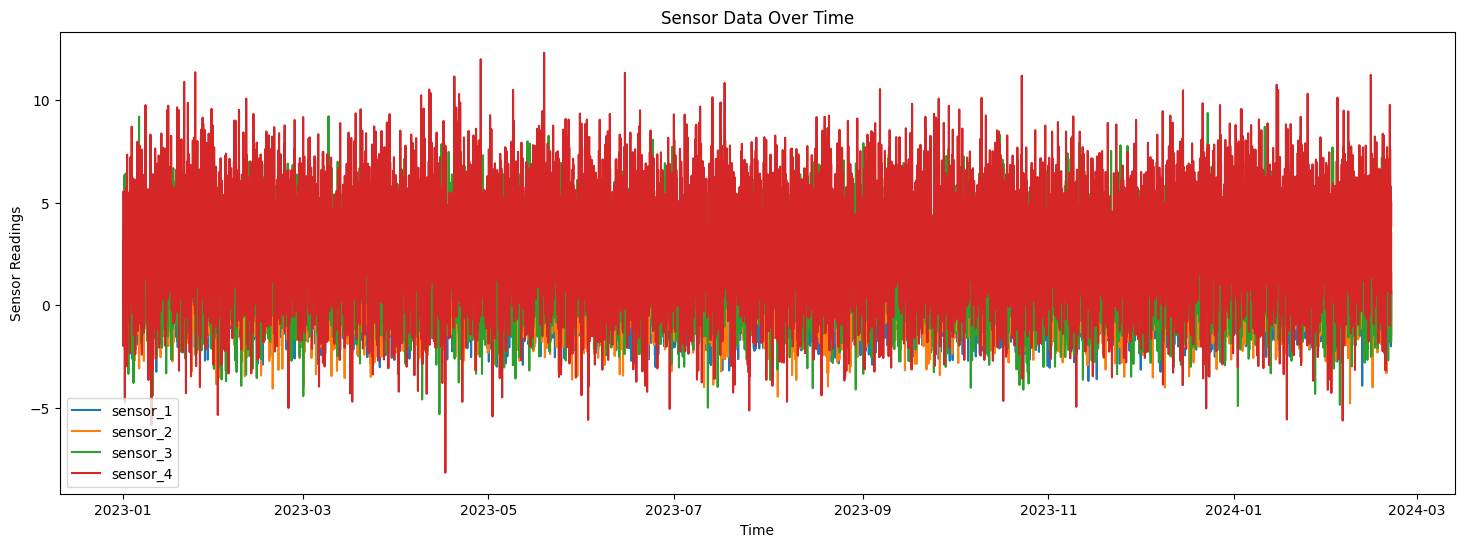

In [ ]:
# Exploratory Data Analysis
# Plot sensor data
plt.figure(figsize=(18, 6))
for column in sensor_data.columns:
    plt.plot(data[column], label=column)
plt.title('Sensor Data Over Time')
plt.xlabel('Time')
plt.ylabel('Sensor Readings')
plt.legend()
plt.show()


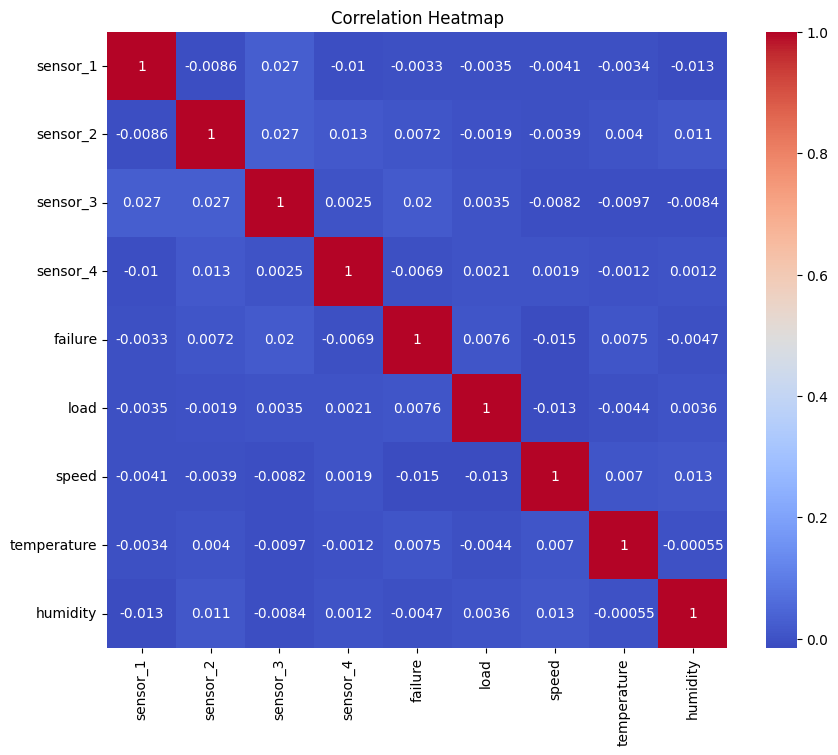

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


###3.1 Time-Based Features:

Extract features like hour of the day, day of the week, month, etc.

###3.2 Lag Features:

Create lagged versions of sensor data to capture temporal dependencies.

###3.3 Rolling Window Statistics:

Compute rolling means, standard deviations, and other statistics for sensor data.



In [ ]:
# Feature Engineering
# Create time-based features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month


In [ ]:
# Create lag features
for lag in range(1, 25):
    for column in sensor_data.columns:
        data[f'{column}_lag_{lag}'] = data[column].shift(lag)


In [ ]:
# Create rolling window statistics
for column in sensor_data.columns:
    data[f'{column}_rolling_mean_3'] = data[column].rolling(window=3).mean()
    data[f'{column}_rolling_std_3'] = data[column].rolling(window=3).std()
    data[f'{column}_rolling_mean_7'] = data[column].rolling(window=7).mean()
    data[f'{column}_rolling_std_7'] = data[column].rolling(window=7).std()


<ipython-input-15-fd8b07fe8359>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{column}_rolling_mean_3'] = data[column].rolling(window=3).mean()
<ipython-input-15-fd8b07fe8359>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{column}_rolling_std_3'] = data[column].rolling(window=3).std()
<ipython-input-15-fd8b07fe8359>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

In [ ]:
# Drop rows with NaN values due to lag and rolling window calculations
data = data.dropna()


In [ ]:
# Train-Test Split
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]


In [ ]:
X_train, y_train = train.drop(columns=['failure']), train['failure']
X_test, y_test = test.drop(columns=['failure']), test['failure']


In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Dimensionality Reduction using PCA
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


###4.1 Classification Models:

Train classifiers (e.g., Random Forest, XGBoost, LSTM) to predict failure events.
Use cross-validation to tune hyperparameters and prevent overfitting.

###4.2 Anomaly Detection Models:

Train models to detect anomalies in sensor data that may indicate impending failures.

###4.3 Ensemble Methods:

Combine predictions from multiple models to improve accuracy and robustness.

In [ ]:
# Model Building
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
# XGBoost Classifier
xgb = XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Reshape data for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
# Train LSTM
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = lstm_model.fit(X_train_lstm, y_train, epochs=40, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/40
98/98 [==============================] - 15s 156ms/step - loss: 0.6801 - accuracy: 0.5817 - val_loss: 0.7511 - val_accuracy: 0.3595
Epoch 2/40
98/98 [==============================] - 12s 124ms/step - loss: 0.6798 - accuracy: 0.5817 - val_loss: 0.7590 - val_accuracy: 0.3595
Epoch 3/40
98/98 [==============================] - 12s 124ms/step - loss: 0.6798 - accuracy: 0.5817 - val_loss: 0.7581 - val_accuracy: 0.3595
Epoch 4/40
98/98 [==============================] - 22s 226ms/step - loss: 0.6799 - accuracy: 0.5817 - val_loss: 0.7461 - val_accuracy: 0.3595
Epoch 5/40
98/98 [==============================] - 16s 163ms/step - loss: 0.6796 - accuracy: 0.5817 - val_loss: 0.7545 - val_accuracy: 0.3595
Epoch 6/40
98/98 [==============================] - 13s 131ms/step - loss: 0.6798 - accuracy: 0.5817 - val_loss: 0.7458 - val_accuracy: 0.3595
Epoch 7/40
98/98 [==============================] - 13s 134ms/step - loss: 0.6794 - accuracy: 0.5817 - val_loss: 0.7532 - val_accuracy: 0.3595

###5.1 Evaluation Metrics:

Precision, Recall, F1-Score for classification.
ROC-AUC for overall model performance.
Confusion matrix to analyze false positives and false negatives.

###5.2 Cross-Validation:

Perform time series cross-validation to assess model performance.
Use backtesting with a rolling window approach.

###5.3 Model Comparison:

Compare the performance of different models based on evaluation metrics.

In [ ]:
# Model Evaluation Function
def evaluate_model(model, X_test, y_test, model_type='other'):
    if model_type == 'lstm':
        preds = (model.predict(X_test) > 0.5).astype("int32")
    else:
        preds = model.predict(X_test)
        if hasattr(model, 'predict_proba'):
            preds_proba = model.predict_proba(X_test)[:, 1]
        else:
            preds_proba = preds

    # Ensure binary predictions for LSTM
    if model_type == 'lstm':
        preds = preds.flatten()

    print(classification_report(y_test, preds))
    print(f'ROC-AUC: {roc_auc_score(y_test, preds)}')
    print(f'Confusion Matrix:\n{confusion_matrix(y_test, preds)}')


In [ ]:
# Evaluate Random Forest
print("Random Forest Evaluation")
evaluate_model(rf, X_test, y_test)


Random Forest Evaluation
              precision    recall  f1-score   support

         0.0       0.87      0.77      0.82      1693
         1.0       0.13      0.23      0.17       251

    accuracy                           0.70      1944
   macro avg       0.50      0.50      0.49      1944
weighted avg       0.78      0.70      0.74      1944

ROC-AUC: 0.5027203648489327
Confusion Matrix:
[[1311  382]
 [ 193   58]]


In [ ]:
# Evaluate XGBoost
print("XGBoost Evaluation")
evaluate_model(xgb, X_test, y_test)


XGBoost Evaluation
              precision    recall  f1-score   support

         0.0       0.87      0.64      0.74      1693
         1.0       0.13      0.37      0.19       251

    accuracy                           0.61      1944
   macro avg       0.50      0.50      0.47      1944
weighted avg       0.78      0.61      0.67      1944

ROC-AUC: 0.5037040261870416
Confusion Matrix:
[[1085  608]
 [ 159   92]]


In [ ]:
# Evaluate LSTM
print("LSTM Evaluation")
evaluate_model(lstm_model, X_test_lstm, y_test, model_type='lstm')



LSTM Evaluation
61/61 [==============================] - 3s 43ms/step
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      1693
         1.0       0.00      0.00      0.00       251

    accuracy                           0.87      1944
   macro avg       0.44      0.50      0.46      1944
weighted avg       0.76      0.87      0.81      1944

ROC-AUC: 0.4985233313644418
Confusion Matrix:
[[1688    5]
 [ 251    0]]


In [ ]:
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curve(y_test, y_scores, model_name):
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name} (AUC = {pr_auc:.2f})')
    plt.show()


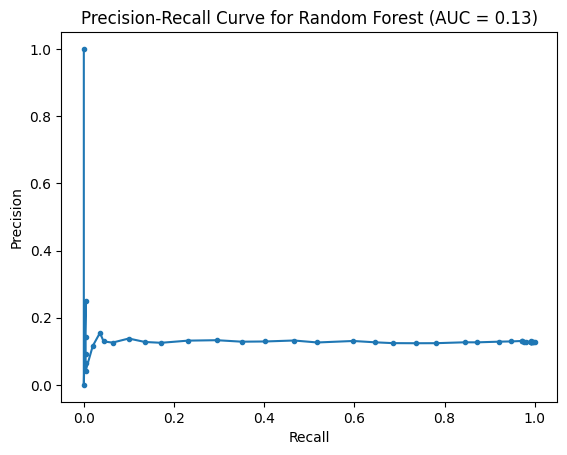

In [ ]:
# Precision-Recall curve for Random Forest
y_scores_rf = rf.predict_proba(X_test)[:, 1]
plot_precision_recall_curve(y_test, y_scores_rf, 'Random Forest')


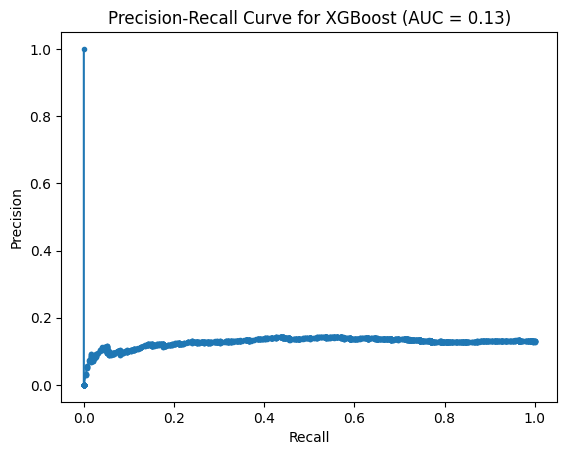

In [ ]:
# Precision-Recall curve for XGBoost
y_scores_xgb = xgb.predict_proba(X_test)[:, 1]
plot_precision_recall_curve(y_test, y_scores_xgb, 'XGBoost')


61/61 [==============================] - 3s 44ms/step


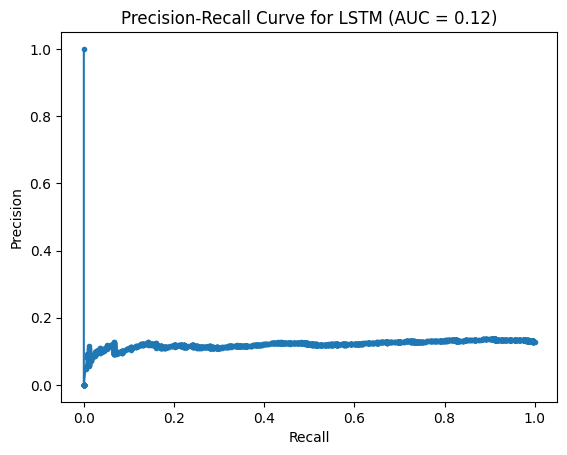

In [ ]:
# Precision-Recall curve for LSTM
y_scores_lstm = lstm_model.predict(X_test_lstm).flatten()
plot_precision_recall_curve(y_test, y_scores_lstm, 'LSTM')


In [ ]:

rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='roc_auc', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
print(f'Best parameters for Random Forest: {rf_grid_search.best_params_}')
rf_best = rf_grid_search.best_estimator_


Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [ ]:
# XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'subsample': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(xgb, xgb_param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='roc_auc', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)
print(f'Best parameters for XGBoost: {xgb_grid_search.best_params_}')
xgb_best = xgb_grid_search.best_estimator_


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.8}


In [ ]:
# Evaluate the tuned models
print("Tuned Random Forest Evaluation")
evaluate_model(rf_best, X_test, y_test)


Tuned Random Forest Evaluation
              precision    recall  f1-score   support

         0.0       0.86      0.70      0.77      1693
         1.0       0.11      0.25      0.15       251

    accuracy                           0.64      1944
   macro avg       0.49      0.48      0.46      1944
weighted avg       0.77      0.64      0.69      1944

ROC-AUC: 0.47657450528659145
Confusion Matrix:
[[1182  511]
 [ 187   64]]


In [ ]:
print("Tuned XGBoost Evaluation")
evaluate_model(xgb_best, X_test, y_test)


Tuned XGBoost Evaluation
              precision    recall  f1-score   support

         0.0       0.87      0.73      0.79      1693
         1.0       0.13      0.26      0.17       251

    accuracy                           0.67      1944
   macro avg       0.50      0.50      0.48      1944
weighted avg       0.77      0.67      0.71      1944

ROC-AUC: 0.4959159228414164
Confusion Matrix:
[[1234  459]
 [ 185   66]]


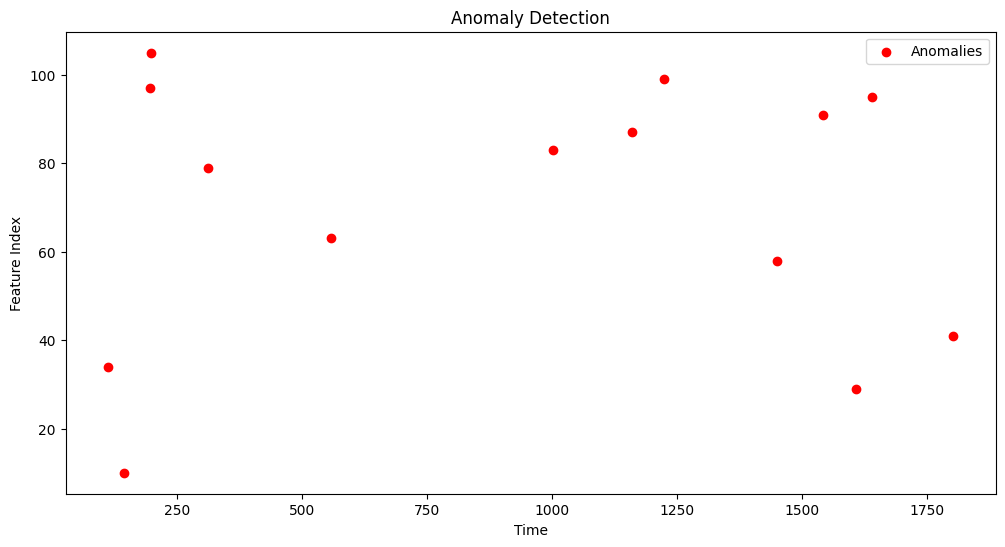

In [ ]:
threshold = 4  # define threshold for z-score
z_scores = np.abs((X_test - np.mean(X_train, axis=0)) / np.std(X_train, axis=0))
anomalies = np.where(z_scores > threshold)

# Visualize anomalies
plt.figure(figsize=(12, 6))
plt.scatter(anomalies[0], anomalies[1], color='red', label='Anomalies')
plt.xlabel('Time')
plt.ylabel('Feature Index')
plt.title('Anomaly Detection')
plt.legend()
plt.show()


In [ ]:
# Feature Importance
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)
    plt.figure(figsize=(30, 30))
    plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()


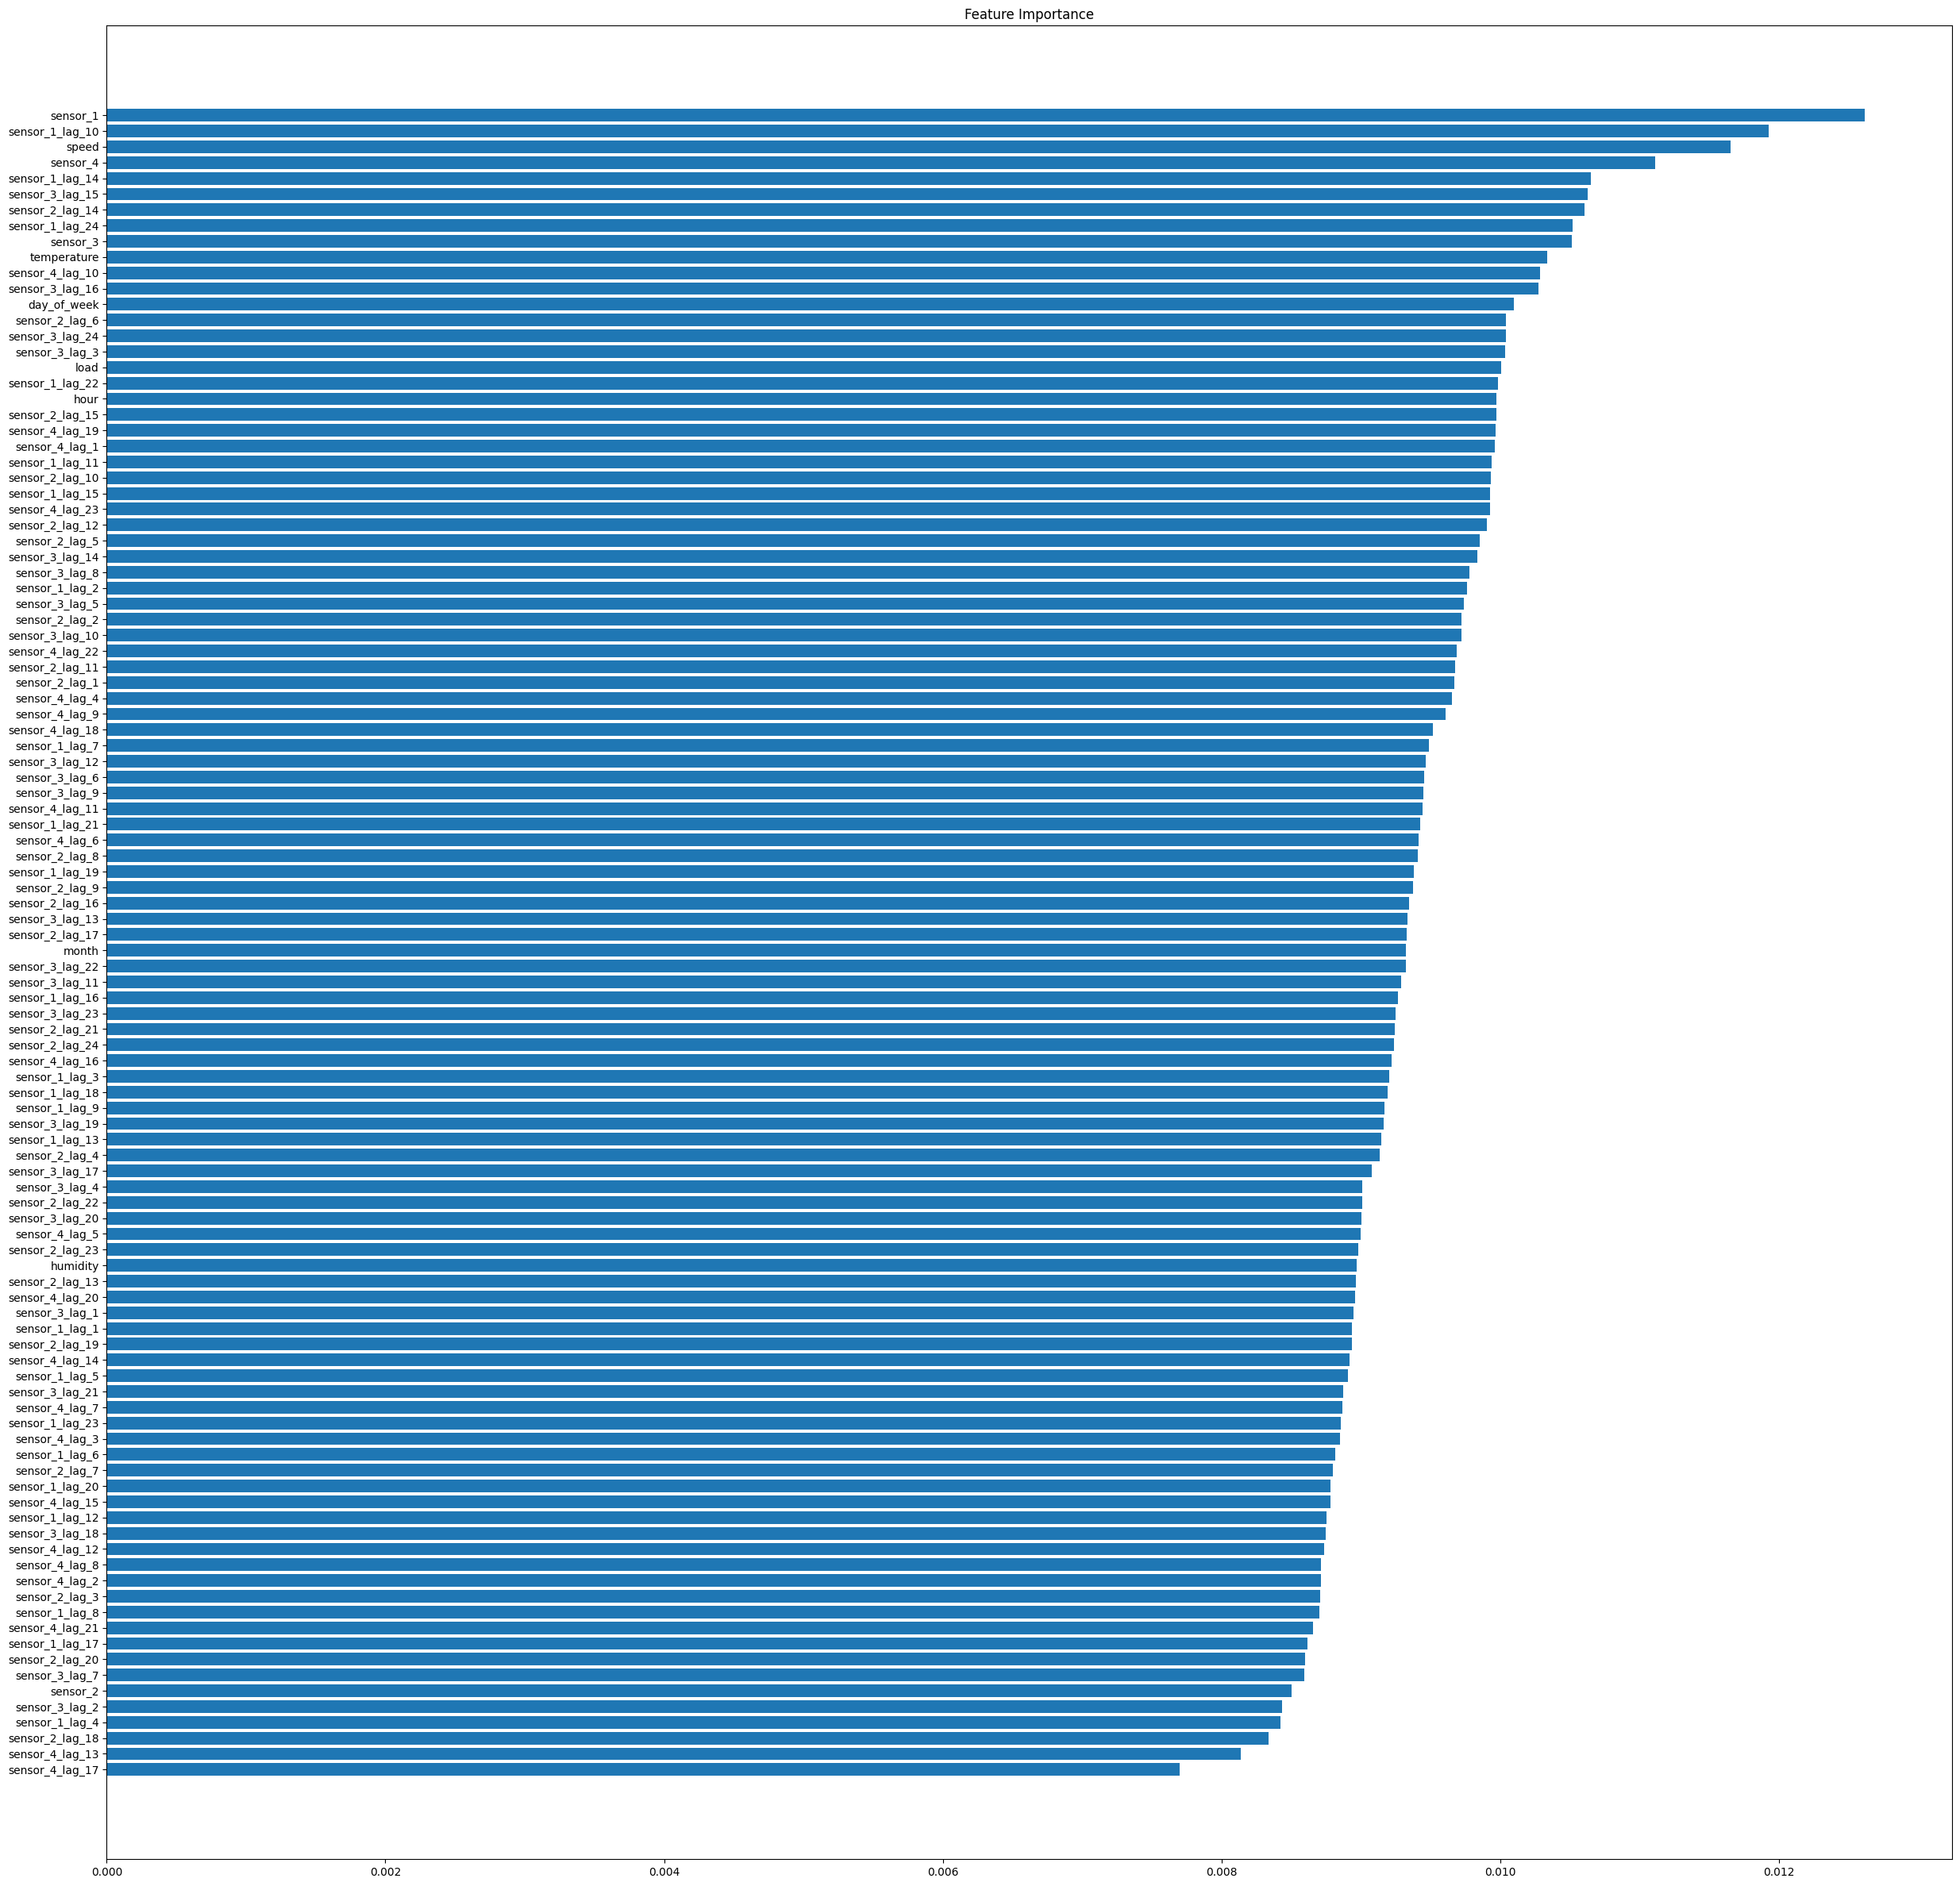

In [ ]:
feature_names = train.drop(columns=['failure']).columns
plot_feature_importance(rf_best, feature_names)


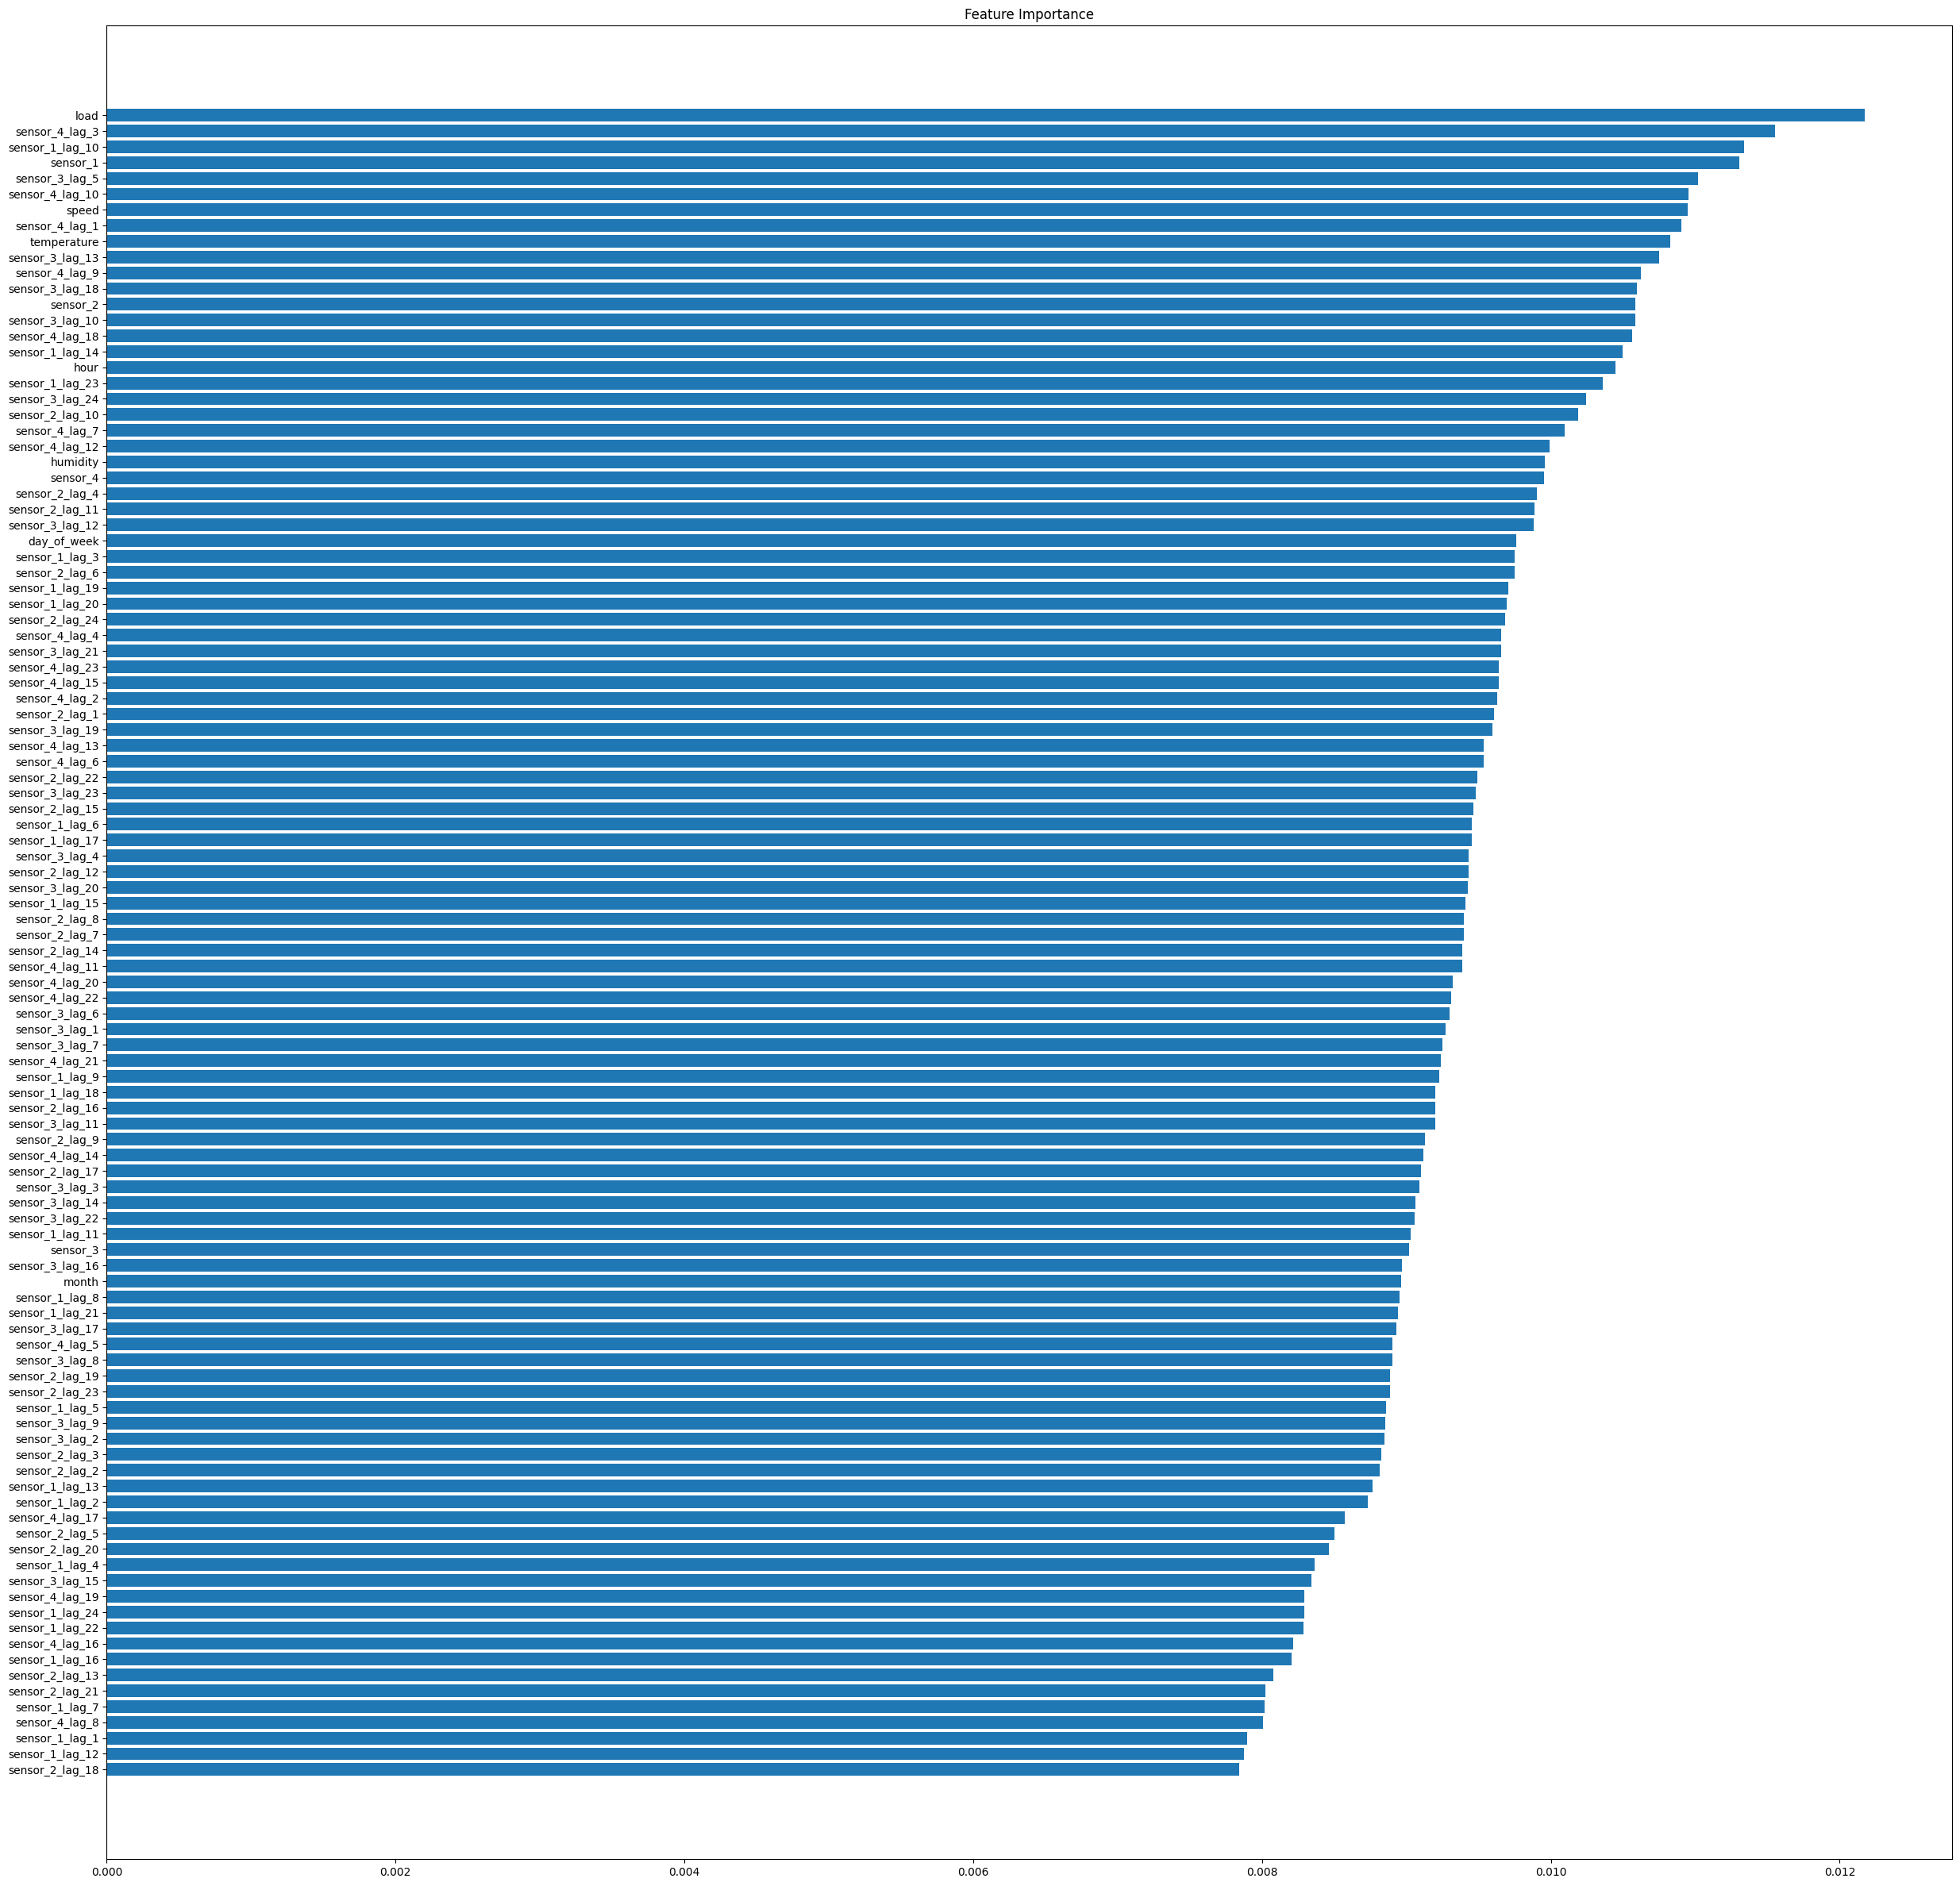

In [ ]:
plot_feature_importance(xgb_best, feature_names)

In [ ]:
# Save the best models
joblib.dump(rf_best, 'random_forest_model.pkl')
joblib.dump(xgb_best, 'xgboost_model.pkl')
lstm_model.save('lstm_model.h5')



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Real-Time Prediction Example
# Load the models
rf_model = joblib.load('random_forest_model.pkl')
xgb_model = joblib.load('xgboost_model.pkl')
from keras.models import load_model
lstm_model = load_model('lstm_model.h5')



In [ ]:
# Predict the next hour failure probability
def predict_next_hour(model, last_row, scaler, pca, model_type='other'):
    last_row_scaled = scaler.transform([last_row])
    last_row_pca = pca.transform(last_row_scaled)
    if model_type == 'lstm':
        last_row_pca = last_row_pca.reshape((last_row_pca.shape[0], last_row_pca.shape[1], 1))
        prediction = model.predict(last_row_pca)
        prediction = (prediction > 0.5).astype("int32").flatten()
    else:
        prediction = model.predict(last_row_pca)
    return prediction


In [ ]:
# Example of predicting the next hour using the last row of the test set
last_row = data.drop(columns=["failure"]).iloc[-1,:]
rf_prediction = predict_next_hour(rf_model, last_row, scaler, pca, model_type='rf')
xgb_prediction = predict_next_hour(xgb_model, last_row, scaler, pca, model_type='xgb')
lstm_prediction = predict_next_hour(lstm_model, last_row, scaler, pca, model_type='lstm')


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 3s 3s/step


In [ ]:
print(f'Random Forest Prediction: {rf_prediction}')
print(f'XGBoost Prediction: {xgb_prediction}')
print(f'LSTM Prediction: {lstm_prediction}')

Random Forest Prediction: [1.]
XGBoost Prediction: [0]
LSTM Prediction: [0]
